<a href="https://colab.research.google.com/github/AdityaGhatty/Datascience/blob/main/Copy_of_Unit5ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Unit 5 Exercises: Leverage + Practice with GLMs

In these exercises, we'll focus on:
- how to recognize high leverage values, and what to do about them.
- how to decide when a generalized linear model is better than than an all normal, straight line model

We'll start  by looking at the full NBA data set from class, and interogate why I removed so many observations from that data set.

We'll finish with another classic data set, some deemographic data from the Kalahari !Kung San people collected by Nancy Howell in Botswana between August 1967 and May 1969.

##Leverage

Let's take a look at the full basketball data set.

In [36]:
#load the data into a pandas dataframe, and print it
url_basketball = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv'
#I could have put the url string directly into pd.read_csv()
basketball = pd.read_csv(url_basketball,dtype={'Pos':'category'})

Before, we put a minutes restriction on what players we looked at, and removed anyone who never missed a free throw.

I've commented out that code, for reference, below. We're going to attempt to run the same analysis without removing any data

In [37]:
#only look at players who played more than 400 minutes
#basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
#basketball = basketball.query('`FT%` != 1.0')

In [38]:
basketball

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


**Task1**:

Make a scatter plot with FT% of each player on the horizontal axis and FG% on the vertical axis.

What patterns do you notice? Why do you think they are there?

<Axes: xlabel='FT%', ylabel='FG%'>

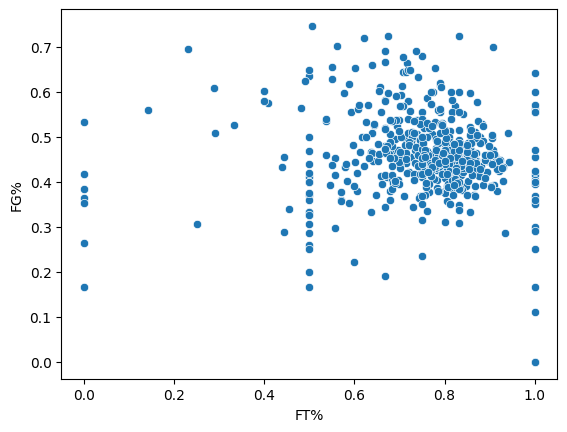

In [39]:
sns.scatterplot(data=basketball, x='FT%', y='FG%')

There are an unusual amount of players with values at 0, 0.5, 0.75, and 1 as a FT%. This may be because of players who don't attempt many free throws for whatever reason, meaning they can have more "normal" numbers like these (1/1, 3/4, etc)

**Task2**:

Make a scatter plot with FT% on the horizontal axis and FG% on the vertical axis. Do this for each each Position in the data set.

Pay special attention to the plots for C and PF.

In [40]:
positions = basketball['Pos'].unique()
positions

['PF-C', 'C', 'SG', 'PF', 'SF', ..., 'PG-SG', 'C-PF', 'PF-SF', 'SF-SG', 'SG-PG']
Length: 12
Categories (12, object): ['C', 'C-PF', 'PF', 'PF-C', ..., 'SF-PF', 'SF-SG', 'SG', 'SG-PG']

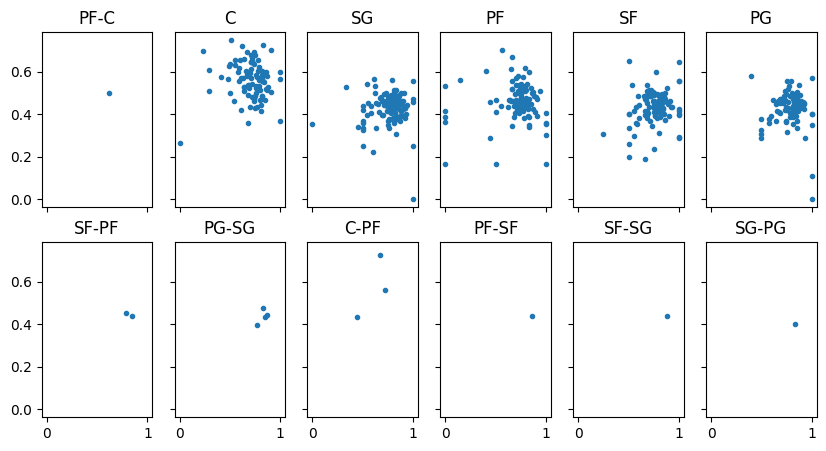

In [41]:

#set up the 12 plots
_, ax = plt.subplots(2, 6, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

#make a scatter plot for each position
for i, p in enumerate(positions):
    ax[i].scatter(
        x = basketball.query('Pos == @p')['FT%'],
        y =  basketball.query('Pos == @p')['FG%'],
        marker=".")
    ax[i].set_title(f"{p}")


**Task3**:

Originally, I was going to get you to create and run an individual linear regression model for each of the positions.

But I couldn't even get model to run.

Explain why a linear regression model won't run on the full dataset. HInt: look at the graphs you made above, and compare and contrast them to the ones from class.

Or: if you do what I could not and get a linear regression model to run on the full data set, I'll give you full credit and a high five.

The high leverage values in the center and power forward positions make the model unable to run. I think large differences in slopes because of the other values that don't fit with the trends. Allowing for large amounts of slopes and intercepts to be possible makes it impossible for the model to work or make predictions.

## From Linear Model to Generalized Linear Model

You'll now fit a linear regression on the height and weight for people or the Kalahari !Kung San people. Height will be the predictor and weight will be the predicted.

Here's the raw data.

In [42]:
#downloads the data from my github
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [43]:
howell

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


**Task4**:

Make a scatter plot of height versus weight for the howell data set.

<Axes: xlabel='height', ylabel='weight'>

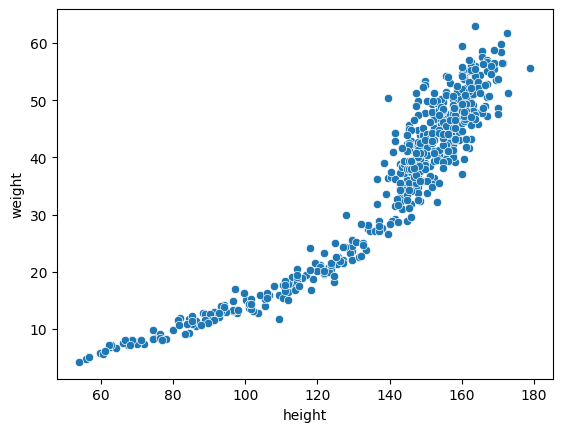

In [44]:
sns.scatterplot(data=howell, x='height', y='weight')

**Task5**:

Create and run a stright line linear regression model on the howell data set with height predicting weight. Visualize your model and its posterior.

In [45]:
height = howell['height']
weight = howell['weight']

with pm.Model() as model:
  alpha = pm.Normal("alpha", sigma=10)
  beta = pm.Normal("beta", sigma=10)
  mu = pm.Deterministic("mu", alpha+beta*height)
  sigma = pm.HalfCauchy("sigma", 10)

  # Likelihood
  likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=weight)

    # Sample from the posterior
  trace = pm.sample()

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['μ'] have not been found and will be ignored
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (547) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'mu\n0'}>,
        <Axes: title={'center': 'mu\n1'}>],
       [<Axes: title={'center': 'mu\n2'}>,
        <Axes: title={'center': 'mu\n3'}>,
        <Axes: title={'center': 'mu\n4'}>,
        <Axes: title={'center': 'mu\n5'}>],
       [<Axes: title={'center': 'mu\n6'}>,
        <Axes: title={'center': 'mu\n7'}>,
        <Axes: title={'center': 'mu\n8'}>,
        <Axes: title={'center': 'mu\n9'}>],
       [<Axes: title={'center': 'mu\n10'}>,
        <Axes: title={'center': 'mu\n11'}>,
        <Axes: title={'center': 'mu\n12'}>,
        <Axes: title={'center': 'mu\n13'}>],
       [<Axes: title={'center': 'mu\n14'}>,
        <Axes: title={'center': 'mu\n15'}>,
        <Axes: title={'center': 'mu\n16'}>,
        <Axes: title={'center': 'mu\n17'}>],
       [<Axes: title={'center': 'mu\n18'}>,
        <Axes: title={'center': 'mu\n19'}>,
        <Axes: title={'center': 'mu\n20'

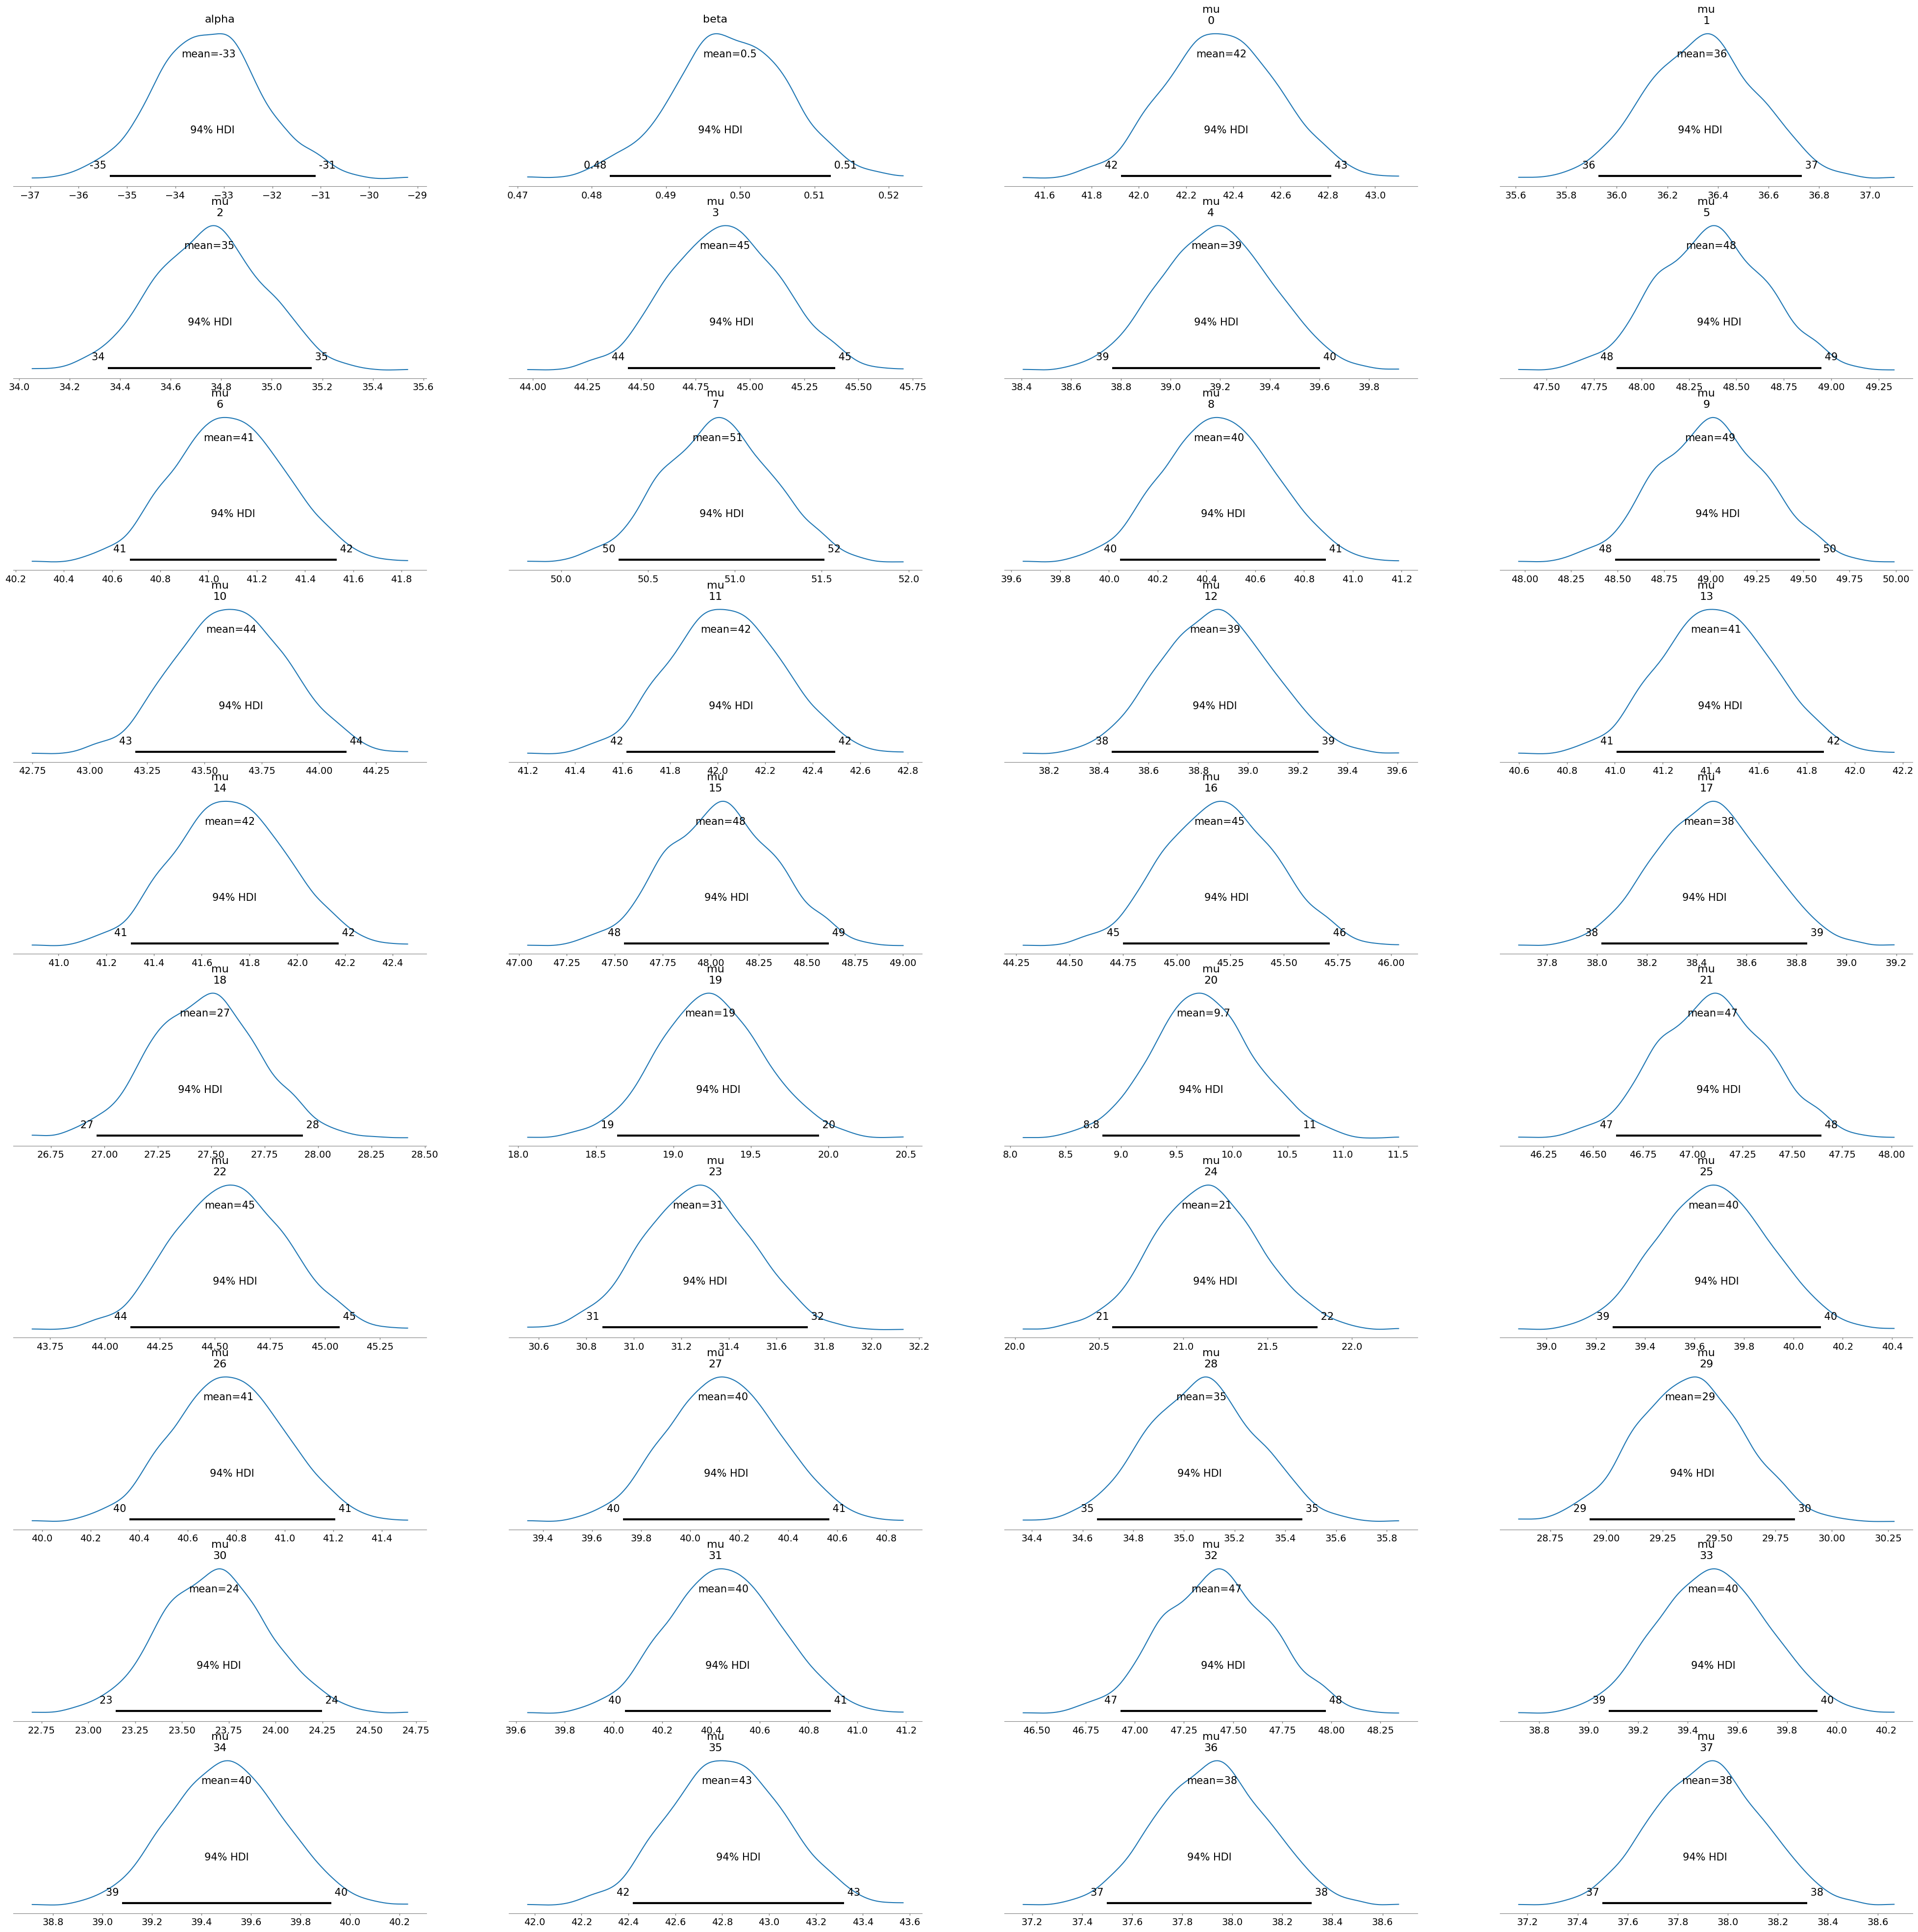

In [46]:
az.plot_posterior(trace, var_names=["~μ"], figsize=(50, 50))

In [50]:
pm.sample_posterior_predictive(
    trace, model, extend_inferencedata=True
)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'weight')

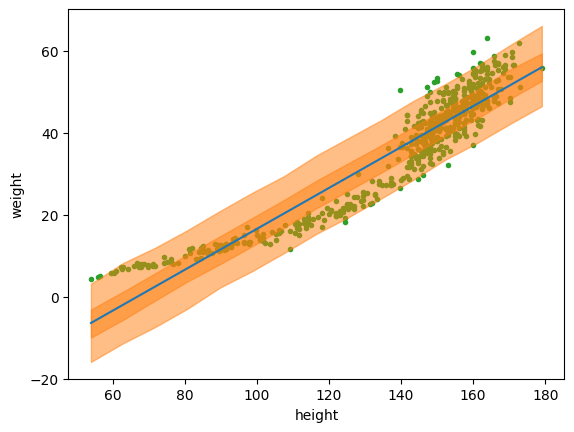

In [54]:
mean_line = trace.posterior["mu"].mean(("chain", "draw"))
xs = np.random.normal(howell.height.values, 0.01)
idx = np.argsort(xs)
x=np.linspace(xs.min(), xs.max(), 15)
y_pred_q = trace.posterior_predictive["likelihood"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(xs[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)
_, ax = plt.subplots()
ax.plot(height, weight, "C2.", zorder=-3)
ax.plot(height[idx], mean_line[idx], c="C0")
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("height")
ax.set_ylabel("weight")

**Task6**:

Run a posterior predictive check for model_howell, plot the posterior predictive distribution, and comment on the fit of the model you made in Task5.

<Axes: xlabel='likelihood'>

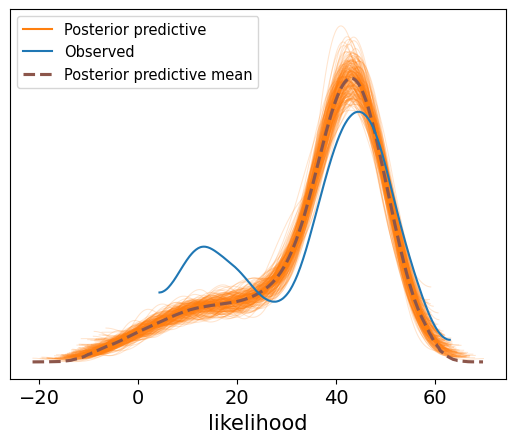

In [55]:
az.plot_ppc(trace, num_pp_samples=200, colors=["C1", "C0", "C5"])

The model is able to somewhat mimic the spike of the observed values around 0.45, but not very well. The negative values should not exist, that may be an issue with the model as well. The model does not accurately show the bump in values around 0.15.

**Task7**:

Create and visualize the posterior of a generalized linear model that improves the on the fit of the model you made in Task5.

In [56]:
with pm.Model() as expmodel:

    #priors for our mean line
    α = pm.Normal("α", mu=30, sigma=10)
    β = pm.Normal("β", mu=0, sigma=0.1)

    #mean line
    μ = pm.Deterministic("μ", α * pm.math.exp(β*howell.height))

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    idata_sqrthow = pm.sample()

Output()

Output()

In [57]:
pm.sample_posterior_predictive(idata_sqrthow, model=expmodel,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'weight')

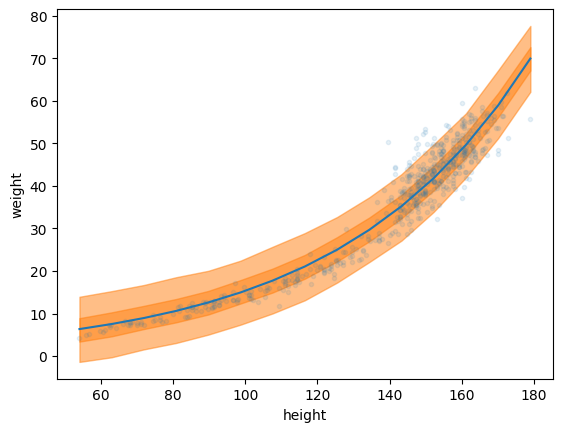

In [58]:
#plots the posterior


x = np.linspace(howell.height.min(), howell.height.max(), 15)
posterior_exp = az.extract(idata_sqrthow)
_, ax = plt.subplots()

alpha_mean = posterior_exp["α"].mean().item()
beta_mean = posterior_exp["β"].mean().item()

ax.plot(howell.height, howell.weight, "C0.", alpha=0.1)

y_pred_q = idata_sqrthow.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)

idx = np.argsort(height)

y_hat_bounds = iter(
    [
        PchipInterpolator(height[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

mean_line = alpha_mean * np.exp(beta_mean* x)

#ax.plot(howell.height, howell.weight, "C3", zorder=-3) #weird red lines
ax.plot(x, mean_line, c="C0", label="Mean Prediction") #mean line

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5) #orange thing

ax.set_xlabel("height")
ax.set_ylabel("weight")

**Task8**:

Run a posterior predictive check, and visualize the posterior predictive distribution, for the model you made in Task7.

Comment on the fit.

In [62]:
pm.sample_posterior_predictive(
    idata_sqrthow, expmodel, extend_inferencedata=True
)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

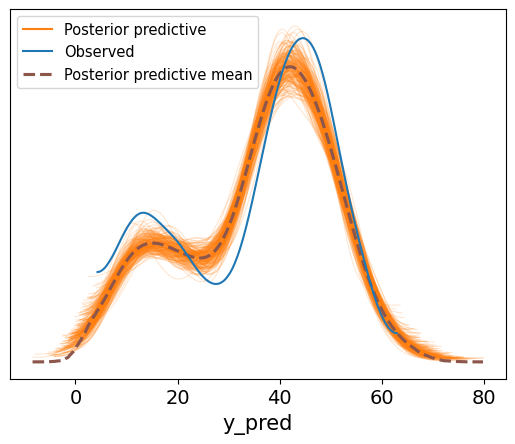

In [63]:
az.plot_ppc(idata_sqrthow, num_pp_samples=200, colors=["C1", "C0", "C5"])

The model fits a lot better, as it's able to adress the issues we had in the normal model. The values mostly end at 0, meaning there are far fewer impossible values, other than what we can't really remove. It fits the smaller spike as well, meaning this is far more tailored to our data.